# Imports

In [7]:
import numpy as np
import pandas as pd
import re
import string
import random
import time
import gc

import nltk
nltk.download('stopwords')
import emoji

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ULTRAPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 3060 Ti


# Data Preparation


In [9]:
df = pd.read_csv('data/offensivelang_dataset.csv')
df

,Comment,Majority_Label
0,ـ الفصل إسم على مسمى يضمن بكتاب آستشارة أو دست...,0
1,أحسن ربنا يولع فيهم,1
2,انا مش عارف عايزين فضيحه اكبر من كده اخلعوا اف...,1
3,والله غالب على أمره ولكن أكثر الناس لايعلمون,0
4,يا أمل يا بطيخ ثنينهم من (حزب الدعوة الايراني)...,1
...,...,...
35687,هؤلاء الأذلاء لا يعلمون أن الأحرار يفضلون المو...,1
35688,اين تعليقي ياجزيرة هل غرق في الجزيرة,1
35689,يقرؤون إحنا كده كنا كده الربع، ليه ماخلوها كنا...,1
35690,ساشفي غليلي قريبا عندما تمحى هذه الطائفة الملعونة,1


In [10]:
test_data = df.sample(frac=0.2,random_state=200)
test_data.shape
data=df.drop(test_data.index)
data.shape,test_data.shape

((28554, 2), (7138, 2))

In [11]:
test_data

,Comment,Majority_Label
2750,انتو خون و ما بطلعلكو تحكو اصلا و لا تقلي حرية...,1
26277,اعان الله اوباما في هذه الإجتماعات، هوز نكست,1
10336,غريب امر الولايات المتحده تدعم وترسخ الدكتاتور...,1
34604,وهي خازوق تاني لقطر والجاي اكتر من الرايح,1
4901,"شو ليئين لبعض , شو طعمين نفس الطعم , كله دماء ...",1
...,...,...
17952,وين المصداقيه ياجزيره... اليوم 36 مدني قتل في ...,1
26192,"موقع ""مغربى"" يفجر مفاجآة وينشر صورة للسيسى داخ...",1
9924,بفضل حكام الاردن فالاردن بالطريق الى التشيع، م...,1
3139,... هههههه... شيئ وحيد ما زال أمام الاخوة المغ...,1


In [12]:
arabic_stopwords = set(nltk.corpus.stopwords.words("arabic"))

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations = arabic_punctuations + english_punctuations


def remove_urls (text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    return text


def remove_emails(text):
    text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", "",  text, flags=re.MULTILINE)
    return text

def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)

def normalization(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text

def remove_stopwords(text):
    filtered_sentence = [w for w in text.split() if not w in arabic_stopwords]
    return ' '.join(filtered_sentence)

def cleaning_content(line):
    if (isinstance(line, float)):
        return None
    line.replace('\n', ' ')
    line = remove_emails(line)
    line = remove_urls(line)
    line = remove_emoji(line)
    nline = [w if '@' not in w else 'USERID' for w in line.split()]
    line = ' '.join(nline)
    line = line.replace('RT', '').replace('<LF>', '').replace('<br />','').replace('&quot;', '').replace('<url>', '').replace('USERID', '')


    # add spaces between punc,
    line = line.translate(str.maketrans({key: " {0} ".format(key) for key in punctuations}))

    # then remove punc,
    translator = str.maketrans('', '', punctuations)
    line = line.translate(translator)

    line = remove_stopwords(line)
    line=remove_diacritics(normalization(line))
    return line

def hasDigits(s):
    return any( 48 <= ord(char) <= 57  or 1632 <= ord(char) <= 1641 for char in s)


In [13]:
df.Comment = df.Comment.apply(cleaning_content)

In [14]:
comments = ' '.join(list(df.Comment))
words = comments.split(' ')

In [16]:
words

['الفصل',
 'اسم',
 'مسمي',
 'يضمن',
 'بكتاب',
 'استشاره',
 'دستره',
 'تحدد',
 'معاييره',
 'وحدود',
 'تعديله',
 'وفقهما',
 'كالاوبءه',
 'ورصد',
 'الزلازل',
 'والبراكين',
 'وزن',
 'جموع',
 'التكسير',
 'صيغه',
 'منتهي',
 'الجموع',
 '٠',
 'احسن',
 'ربنا',
 'يولع',
 'فيهم',
 'انا',
 'مش',
 'عارف',
 'عايزين',
 'فضيحه',
 'اكبر',
 'كده',
 'اخلعوا',
 'افضل',
 'لان',
 'الكل',
 'عرف',
 'فشلكم',
 'الزريع',
 'وتدمركم',
 'للبلد',
 'والله',
 'غالب',
 'امره',
 'الناس',
 'لايعلمون',
 'امل',
 'بطيخ',
 'ثنينهم',
 'حزب',
 'الدعوه',
 'الايراني',
 'فقط',
 'المهه',
 'تختلف',
 'واحد',
 'يلطم',
 'والثاني',
 'يسوي',
 'الهريسه',
 'شكلك',
 'كوكب',
 'اخر',
 'والعبادي',
 'والسيستاني',
 'متهمين',
 'جمهورهم',
 'بتعيين',
 'الفاسدين',
 'يضعوا',
 'الرمادي',
 'يجب',
 'العدل',
 'باتهام',
 'رءوس',
 'الفساد',
 'فالسيستاني',
 'راس',
 'الافعي',
 'عين',
 'المالكي',
 'والعبادي',
 'الاناء',
 'ينضح',
 'ههههه',
 'اين',
 'هربت',
 'مليشيات',
 'مصراته',
 'فجر',
 'ليبيا',
 'تجبرت',
 'وطغت',
 'البلاد',
 'يتم',
 'سحقها',
 'قبل',
 'انصار

In [17]:
unigram = (pd.Series(nltk.ngrams(words, 1)).value_counts())[:20]
unigram

(و,)            12268
(الله,)          7066
(ان,)            4439
(الي,)           2315
(الجزيره,)       1571
(الا,)           1510
(الدوله,)        1489
(مصر,)           1480
(السعوديه,)      1410
(او,)            1343
(كان,)           1341
(ايران,)         1269
(الاسلاميه,)     1228
(السيسي,)        1226
(والله,)         1165
(اللهم,)         1157
(العرب,)         1128
(المسلمين,)      1075
(انت,)            999
(الشعب,)          994
dtype: int64

In [18]:
tokenizer = BertTokenizer.from_pretrained('aubmindlab/bert-base-arabertv02', do_lower_case=True)

MAX_LEN = 256

def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=cleaning_content(sent),  
            add_special_tokens=True,        
            max_length=MAX_LEN,             
            pad_to_max_length=True,         
            return_attention_mask=True      
        )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [19]:
data["Majority_Label"].replace({"Non-Offensive":"0","Offensive":"1"},inplace=True)
test_data["Majority_Label"].replace({"Non-Offensive":"0","Offensive":"1"},inplace=True)

In [21]:
data

,Comment,Majority_Label
0,ـ الفصل إسم على مسمى يضمن بكتاب آستشارة أو دست...,0
2,انا مش عارف عايزين فضيحه اكبر من كده اخلعوا اف...,1
3,والله غالب على أمره ولكن أكثر الناس لايعلمون,0
4,يا أمل يا بطيخ ثنينهم من (حزب الدعوة الايراني)...,1
5,والعبادي والسيستاني متهمين عند جمهورهم بتعيين ...,1
...,...,...
35687,هؤلاء الأذلاء لا يعلمون أن الأحرار يفضلون المو...,1
35688,اين تعليقي ياجزيرة هل غرق في الجزيرة,1
35689,يقرؤون إحنا كده كنا كده الربع، ليه ماخلوها كنا...,1
35690,ساشفي غليلي قريبا عندما تمحى هذه الطائفة الملعونة,1


In [23]:
max_len = 512

all_tweets = np.concatenate([data.Comment.values, test_data.Comment.values])

encoded_comments = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

max_len1 = max([len(sent) for sent in encoded_comments])
print('Max length: ', max_len1)

Max length:  823


In [24]:

all_tweets = np.concatenate([data.Comment.values, test_data.Comment.values])

encoded_comments = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

max_len1 = max([len(sent) for sent in encoded_comments])
print('Max length: ', max_len1)

Max length:  823


In [25]:
X_train = data.Comment.values
Y_train = data.Majority_Label.values

X_val= test_data.Comment.values
Y_val = test_data.Majority_Label.values

In [26]:
token_ids = list(preprocessing_for_bert([X_train[0]])[0].squeeze().numpy())

print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\ULTRAPC\anaconda3\envs\torch\lib\site-packages\transformers\tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Tokenizing data...


In [27]:
val_inputs

tensor([[    2,   740,   185,  ...,     0,     0,     0],
        [    2,  1535,   303,  ...,     0,     0,     0],
        [    2,  8830,  6177,  ...,     0,     0,     0],
        ...,
        [    2,  5114, 11728,  ...,     0,     0,     0],
        [    2,   138,   195,  ...,     0,     0,     0],
        [    2, 17855,  1958,  ...,     0,     0,     0]])

In [28]:

train_labels = torch.tensor(Y_train.astype(float))
val_labels = torch.tensor(Y_val.astype(float))

In [29]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


In [ ]:
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        #  hidden size of BERT, hidden size of our classifier, number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('aubmindlab/bert-base-arabertv02')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """

        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)  
        
        # Extract the last hidden state of the token `[CLS]` for classification task and feed them to classifier to compute logits 
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 14.5 ms, sys: 109 µs, total: 14.6 ms
Wall time: 19.2 ms


In [ ]:
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    bert_classifier = BertClassifier(freeze_bert=False)

    bert_classifier.to(device)

    optimizer = AdamW(bert_classifier.parameters(),lr=0.0001,eps=1e-8)

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
loss_func = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            
            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RN
            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)
            
            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels.long())
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
        #torch.save(model.state_dict(), './mymodel.h5')
        #model.save_pretrained('./mymodel.h5',model)
        torch.save(model, './mymodel1.h5')
        
    torch.save(model, './mymodel1.h5')
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels.long())
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:

gc.collect()

torch.cuda.empty_cache()

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=3)
train(bert_classifier, train_dataloader, val_dataloader, epochs=3, evaluation=True)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.422548   |     -      |     -     |   55.82  
   1    |   40    |   0.394227   |     -      |     -     |   52.59  
   1    |   60    |   0.276862   |     -      |     -     |   52.53  
   1    |   80    |   0.286909   |     -      |     -     |   52.52  
   1    |   99    |   0.288166   |     -      |     -     |   49.88  
----------------------------------------------------------------------
   1    |    -    |   0.335086   |  0.275426  |   87.88   |  288.55  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.159476   |     -      |     -     |   55.11  
   2    |   40    |   0.195612   |     -      |     -     |   52.

In [ ]:

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9079
Accuracy: 90.75%


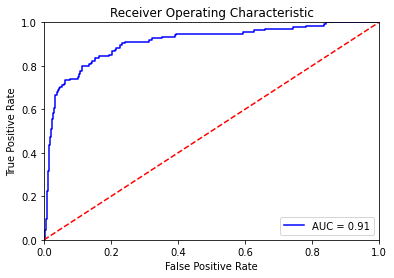

In [ ]:
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, Y_val.astype(float))

In [ ]:
def predict_single_item(loaded_model, tokenizer, label_encoder, text):
    data=[]
    text = data_preparation.clean_content(text)

    data.append(text)
    x_feat = tokenizer.transform(data)
    dense = x_feat.toarray()
    if(dense[0].sum()==0.0):
        lab = "None"
        prob = 1.0
        return lab, prob
    result = loaded_model.predict(x_feat)
    result = label_encoder.inverse_transform(result)
    # class_probabilities = loaded_model.predict_proba(x_feat)[0]

    # prob_per_class_dictionary = dict(zip(label_encoder.classes_, class_probabilities))
    lab=result[0]
    # prob = prob_per_class_dictionary.get(lab)

    return lab #,prob

In [ ]:
text="فقط للتصحيح، مدة الاحتكار حسب إتفاقية تريبس تبتدأ فور تسجيل الدواء كإختراع ملموس ماديا و ليس من وقت بدأ الابحاث، يعني العشرين سنة مضمونة لا وممكن تزيد لأكثة من عشرين سنة هدا ما يطلق عليه تريبس  "
lab=predict_single_item(model, tokenizer, label_encoder, text)
print("class label: %s" % (lab))

NameError: ignored